In [17]:
import tweepy
import json
from pymongo import MongoClient
from collections import Counter
from collections.abc import MutableMapping
import logging
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import community
import seaborn as sns
from fastprogress import master_bar, progress_bar
import time
import re

#Logger
logging.basicConfig(filename='Heatmap2.log', format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logging.getLogger().addHandler(ch)

In [6]:
########################
#          CHES         #
########################

CHES_ideological_position ={}

CHES_ideological_position['VOX'] = [9.71]
CHES_ideological_position['PP'] = [8.06]
CHES_ideological_position['CS'] = [7.20]
CHES_ideological_position['PDECAT'] = [6.66]
CHES_ideological_position['PSOE'] = [3.60]
CHES_ideological_position['ERC'] = [3.20]
CHES_ideological_position['MAS_PAIS'] = [2.73]
CHES_ideological_position['PODEMOS'] = [1.93]
CHES_ideological_position['IU'] = [1.86]

print(CHES_ideological_position)

{'VOX': [9.71], 'PP': [8.06], 'CS': [7.2], 'PDECAT': [6.66], 'PSOE': [3.6], 'ERC': [3.2], 'MAS_PAIS': [2.73], 'PODEMOS': [1.93], 'IU': [1.86]}


In [7]:
########################
# PREPARE HEATMAP DATA #
########################

COMMUNITIES_LIST = ["VOX", "PP", "CS", "PDECAT", "PSOE", "ERC", "MAS_PAIS", "PODEMOS", "IU"]


matrix = np.zeros((len(COMMUNITIES_LIST),len(COMMUNITIES_LIST)))

for A in COMMUNITIES_LIST:
    for B in COMMUNITIES_LIST:
        a = np.array(CHES_ideological_position[A])
        b = np.array(CHES_ideological_position[B])
        distance = np.linalg.norm(a-b)
        #https://en.wikipedia.org/wiki/Euclidean_distance
                
        matrix[COMMUNITIES_LIST.index(A)][COMMUNITIES_LIST.index(B)] = distance 
        
print(matrix)  

[[0.   1.65 2.51 3.05 6.11 6.51 6.98 7.78 7.85]
 [1.65 0.   0.86 1.4  4.46 4.86 5.33 6.13 6.2 ]
 [2.51 0.86 0.   0.54 3.6  4.   4.47 5.27 5.34]
 [3.05 1.4  0.54 0.   3.06 3.46 3.93 4.73 4.8 ]
 [6.11 4.46 3.6  3.06 0.   0.4  0.87 1.67 1.74]
 [6.51 4.86 4.   3.46 0.4  0.   0.47 1.27 1.34]
 [6.98 5.33 4.47 3.93 0.87 0.47 0.   0.8  0.87]
 [7.78 6.13 5.27 4.73 1.67 1.27 0.8  0.   0.07]
 [7.85 6.2  5.34 4.8  1.74 1.34 0.87 0.07 0.  ]]


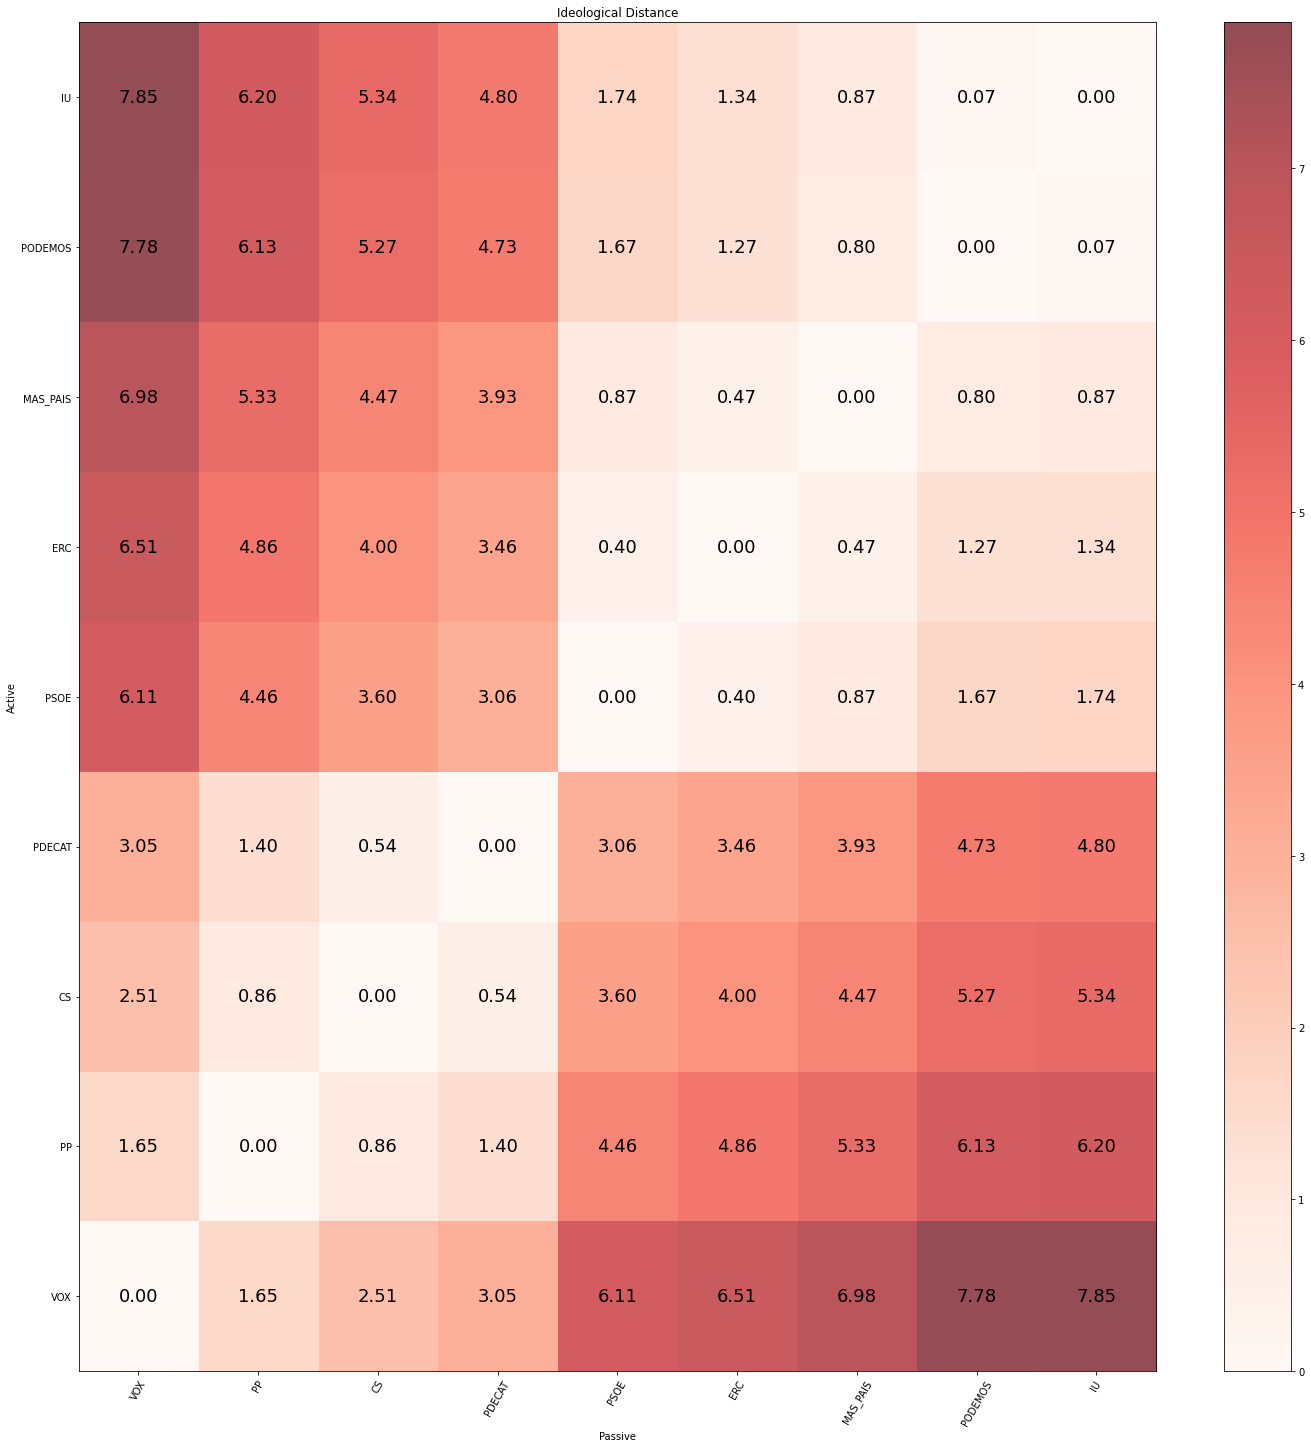

In [9]:
################
# PLOT HEATMAP #
################

def plot_heatmap(m, x_values, y_values, title, xlabel, ylabel, save_fig=False, label_rotation=None):
    """
        Creates a heatmap image from a numpy matrix.

    :param m: 2-dimensional numpy matrix with values to plot
    :param x_values: list of strings for xticks
    :param y_values: list of strings for yticks
    :param title: string, title of the plot
    :param xlabel: string, label of the x axis
    :param ylabel: string, label of the y axis
    :param save_fig: False / "show" / figname , do not show imatge / show it inline / write it to pdf (figure name)
    :param label_rotation: None / int, whether to rotate x ticks (degrees)
    :return:
    """
    
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 1, 1)

    im = ax.imshow(m.transpose(), origin='lower', cmap='Reds', alpha=0.7, aspect='auto')
    #im = ax.imshow(m.transpose(), origin='lower', cmap='jet', alpha=0.7)

    # Colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Loop over data dimensions and create text annotations.
    mt = m.transpose()
    for i in range(len(x_values)):
        for j in range(len(y_values)):
            text = ax.text(j, i, "{:.2f}".format(mt[i, j]), ha="center", va="center", color="black", alpha=1, fontsize=18)

    # Named ticks
    ax.set_xticks(np.arange(len(x_values)))
    ax.set_yticks(np.arange(len(y_values)))
    ax.set_xticklabels(x_values)
    ax.set_yticklabels(y_values)

    # Axis labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Rotate x labels
    if label_rotation:
        plt.xticks(rotation=label_rotation)

    fig.tight_layout()
    plt.title(title)
    
    plt.rcParams.update({'font.size': 24})

    # Output result
    if not save_fig:
        pass
    elif save_fig == "show":
        plt.show()
    else:
        plt.savefig(save_fig + '.pdf', format='pdf', dpi=600)
        plt.close()

        
######INPUT DATA#####

m = matrix
x_values = COMMUNITIES_LIST
y_values = COMMUNITIES_LIST
title = "Ideological Distance"
xlabel = "Passive"
ylabel = "Active"
save_fig = "show"

plot_heatmap(m, x_values, y_values, title, xlabel, ylabel, save_fig, 60)

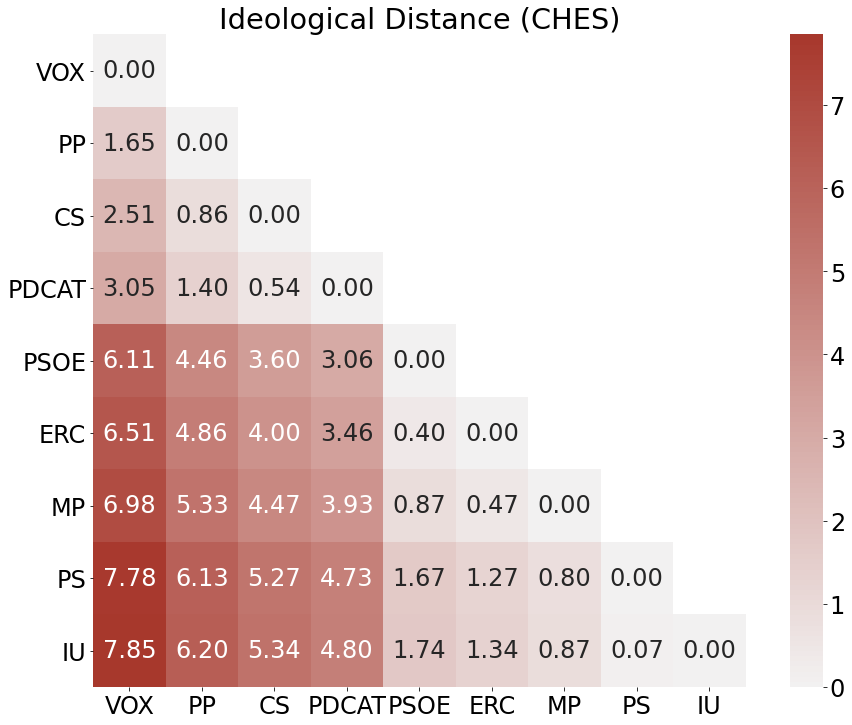

In [12]:
################################
# PLOT HEATMAP (NO REDUNDANCY) #
################################

COMMUNITIES_LIST = ["VOX", "PP", "CS", "PDCAT", "PSOE", "ERC", "MP", "PS", "IU"]

matrix_df = pd.DataFrame(data=matrix,    # values
              index=COMMUNITIES_LIST,    # 1st column as index
              columns=COMMUNITIES_LIST)  # 1st row as the column names

# Calculate pairwise-correlation
m2 = matrix_df.corr()

# Create a mask
mask = np.triu(np.ones_like(m2, dtype=bool))

np.fill_diagonal(mask, False)

# Create a custom divergin palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                            n=9, center="light", as_cmap=True)

plt.figure(figsize=(16, 12))
sns.heatmap(matrix_df, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap)

plt.title("Ideological Distance (CHES)")

#plt.savefig("HEATMAP-CHES.png")
plt.show()

In [13]:
#############################################
#          MANIFESTO RESEARCH GROUP         #
#############################################

Manifesto_ideological_position ={}

Manifesto_ideological_position['VOX'] = [8.30]
Manifesto_ideological_position['PP'] = [5.45]
Manifesto_ideological_position['CUP'] = [4.11]
Manifesto_ideological_position['CS'] = [3.47]
Manifesto_ideological_position['JXCAT'] = [3.31]
Manifesto_ideological_position['ERC'] = [2.26]
Manifesto_ideological_position['PSOE'] = [2.13]
Manifesto_ideological_position['MAS_PAIS'] = [1.99]
Manifesto_ideological_position['PODEMOS'] = [1.24]
Manifesto_ideological_position['IU'] = [1.03]

print(Manifesto_ideological_position)

{'VOX': [8.3], 'PP': [5.45], 'CUP': [4.11], 'CS': [3.47], 'JXCAT': [3.31], 'ERC': [2.26], 'PSOE': [2.13], 'MAS_PAIS': [1.99], 'PODEMOS': [1.24], 'IU': [1.03]}


In [14]:
########################
# PREPARE HEATMAP DATA #
########################


COMMUNITIES_LIST = ["VOX", "PP", "CUP", "CS", "JXCAT", "ERC", "PSOE", "MAS_PAIS", "PODEMOS", "IU"]


matrix = np.zeros((len(COMMUNITIES_LIST),len(COMMUNITIES_LIST)))

for A in COMMUNITIES_LIST:
    for B in COMMUNITIES_LIST:
        a = np.array(Manifesto_ideological_position[A])
        b = np.array(Manifesto_ideological_position[B])
        distance = np.linalg.norm(a-b)
        #https://en.wikipedia.org/wiki/Euclidean_distance
                
        matrix[COMMUNITIES_LIST.index(A)][COMMUNITIES_LIST.index(B)] = distance #TO:DO: Revise SCALING!!
        
print(matrix)  

[[0.   2.85 4.19 4.83 4.99 6.04 6.17 6.31 7.06 7.27]
 [2.85 0.   1.34 1.98 2.14 3.19 3.32 3.46 4.21 4.42]
 [4.19 1.34 0.   0.64 0.8  1.85 1.98 2.12 2.87 3.08]
 [4.83 1.98 0.64 0.   0.16 1.21 1.34 1.48 2.23 2.44]
 [4.99 2.14 0.8  0.16 0.   1.05 1.18 1.32 2.07 2.28]
 [6.04 3.19 1.85 1.21 1.05 0.   0.13 0.27 1.02 1.23]
 [6.17 3.32 1.98 1.34 1.18 0.13 0.   0.14 0.89 1.1 ]
 [6.31 3.46 2.12 1.48 1.32 0.27 0.14 0.   0.75 0.96]
 [7.06 4.21 2.87 2.23 2.07 1.02 0.89 0.75 0.   0.21]
 [7.27 4.42 3.08 2.44 2.28 1.23 1.1  0.96 0.21 0.  ]]


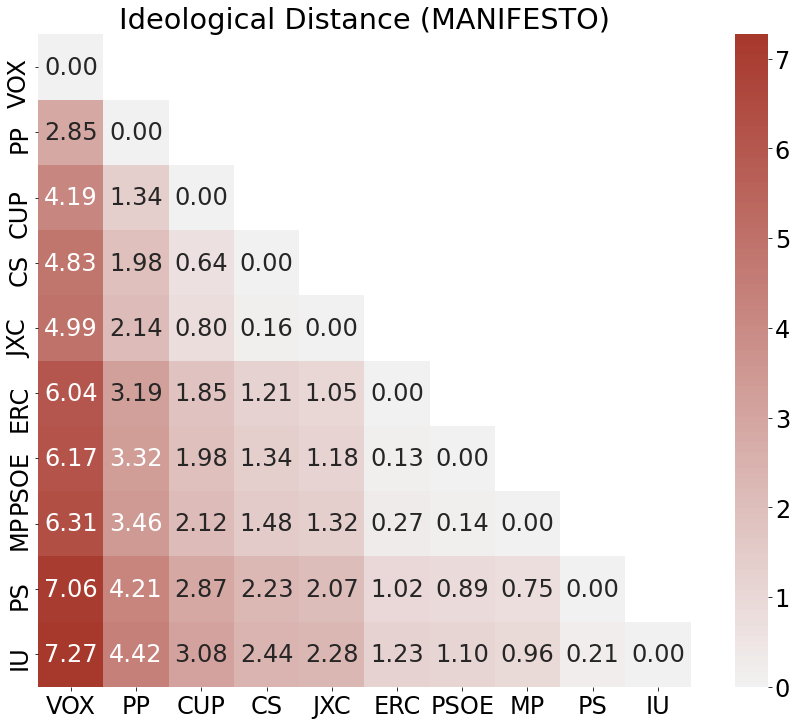

In [17]:
################################
# PLOT HEATMAP (NO REDUNDANCY) #
################################

COMMUNITIES_LIST = ["VOX", "PP", "CUP", "CS", "JXC", "ERC", "PSOE", "MP", "PS", "IU"]

matrix_df = pd.DataFrame(data=matrix,    # values
              index=COMMUNITIES_LIST,    # 1st column as index
              columns=COMMUNITIES_LIST)  # 1st row as the column names

# Calculate pairwise-correlation
m2 = matrix_df.corr()

# Create a mask
mask = np.triu(np.ones_like(m2, dtype=bool))

np.fill_diagonal(mask, False)

# Create a custom divergin palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                            n=9, center="light", as_cmap=True)

plt.figure(figsize=(16, 12))
sns.heatmap(matrix_df, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap)

plt.title("Ideological Distance (MANIFESTO)")

#plt.savefig("HEATMAP-MANIFESTO.png")
plt.show()

In [18]:
###########################################
#          REGIONAL MANIFESTO CAT         #
###########################################

CEO_ideological_position ={}

CEO_ideological_position['CiudadanosCs'] = [6.04, 4.39]
CEO_ideological_position['JuntsXCat'] = [4.94, 6.29]
CEO_ideological_position['Esquerra_ERC'] = [2.94, 7.11]
CEO_ideological_position['socialistes_cat'] = [5.31, 5.36]
CEO_ideological_position['EnComu_Podem'] = [2.70, 5.78]
CEO_ideological_position['cupnacional'] = [1.51, 6.84]
CEO_ideological_position['populares'] = [9.57, 4.67]
CEO_ideological_position['vox_es'] = [8.33, 1.32]

print(CEO_ideological_position)

{'CiudadanosCs': [6.04, 4.39], 'JuntsXCat': [4.94, 6.29], 'Esquerra_ERC': [2.94, 7.11], 'socialistes_cat': [5.31, 5.36], 'EnComu_Podem': [2.7, 5.78], 'cupnacional': [1.51, 6.84], 'populares': [9.57, 4.67], 'vox_es': [8.33, 1.32]}


In [19]:
########################
# PREPARE HEATMAP DATA #
########################


COMMUNITIES_LIST = ["VOX", "PP", "CS", "PSC", "COMUNS", "ERC", "CUP", "JXCAT"]
PARTY_NAMES_LIST = ['vox_es', 'populares', 'CiudadanosCs', 'socialistes_cat',
                    'EnComu_Podem','Esquerra_ERC', 'cupnacional', 'JuntsXCat']


matrix = np.zeros((len(COMMUNITIES_LIST),len(COMMUNITIES_LIST)))

for A in COMMUNITIES_LIST:
    for B in COMMUNITIES_LIST:
        a = np.array(CEO_ideological_position[PARTY_NAMES_LIST[COMMUNITIES_LIST.index(A)]])
        b = np.array(CEO_ideological_position[PARTY_NAMES_LIST[COMMUNITIES_LIST.index(B)]])
        distance = np.linalg.norm(a-b)
        #https://en.wikipedia.org/wiki/Euclidean_distance
                
        matrix[COMMUNITIES_LIST.index(A)][COMMUNITIES_LIST.index(B)] = distance #TO:DO: Revise SCALING!!
        
print(matrix)   

[[0.         3.57212822 3.83001305 5.04400634 7.18251349 7.91051199
  8.77398427 6.01606183]
 [3.57212822 0.         3.5410874  4.31551851 6.95909477 7.06473637
  8.34700545 4.9052319 ]
 [3.83001305 3.5410874  0.         1.21400165 3.61769263 4.12412415
  5.15008738 2.19544984]
 [5.04400634 4.31551851 1.21400165 0.         2.64357712 2.94608214
  4.07803874 1.0008996 ]
 [7.18251349 6.95909477 3.61769263 2.64357712 0.         1.35148067
  1.59364362 2.29732453]
 [7.91051199 7.06473637 4.12412415 2.94608214 1.35148067 0.
  1.4552663  2.1615735 ]
 [8.77398427 8.34700545 5.15008738 4.07803874 1.59364362 1.4552663
  0.         3.47381635]
 [6.01606183 4.9052319  2.19544984 1.0008996  2.29732453 2.1615735
  3.47381635 0.        ]]


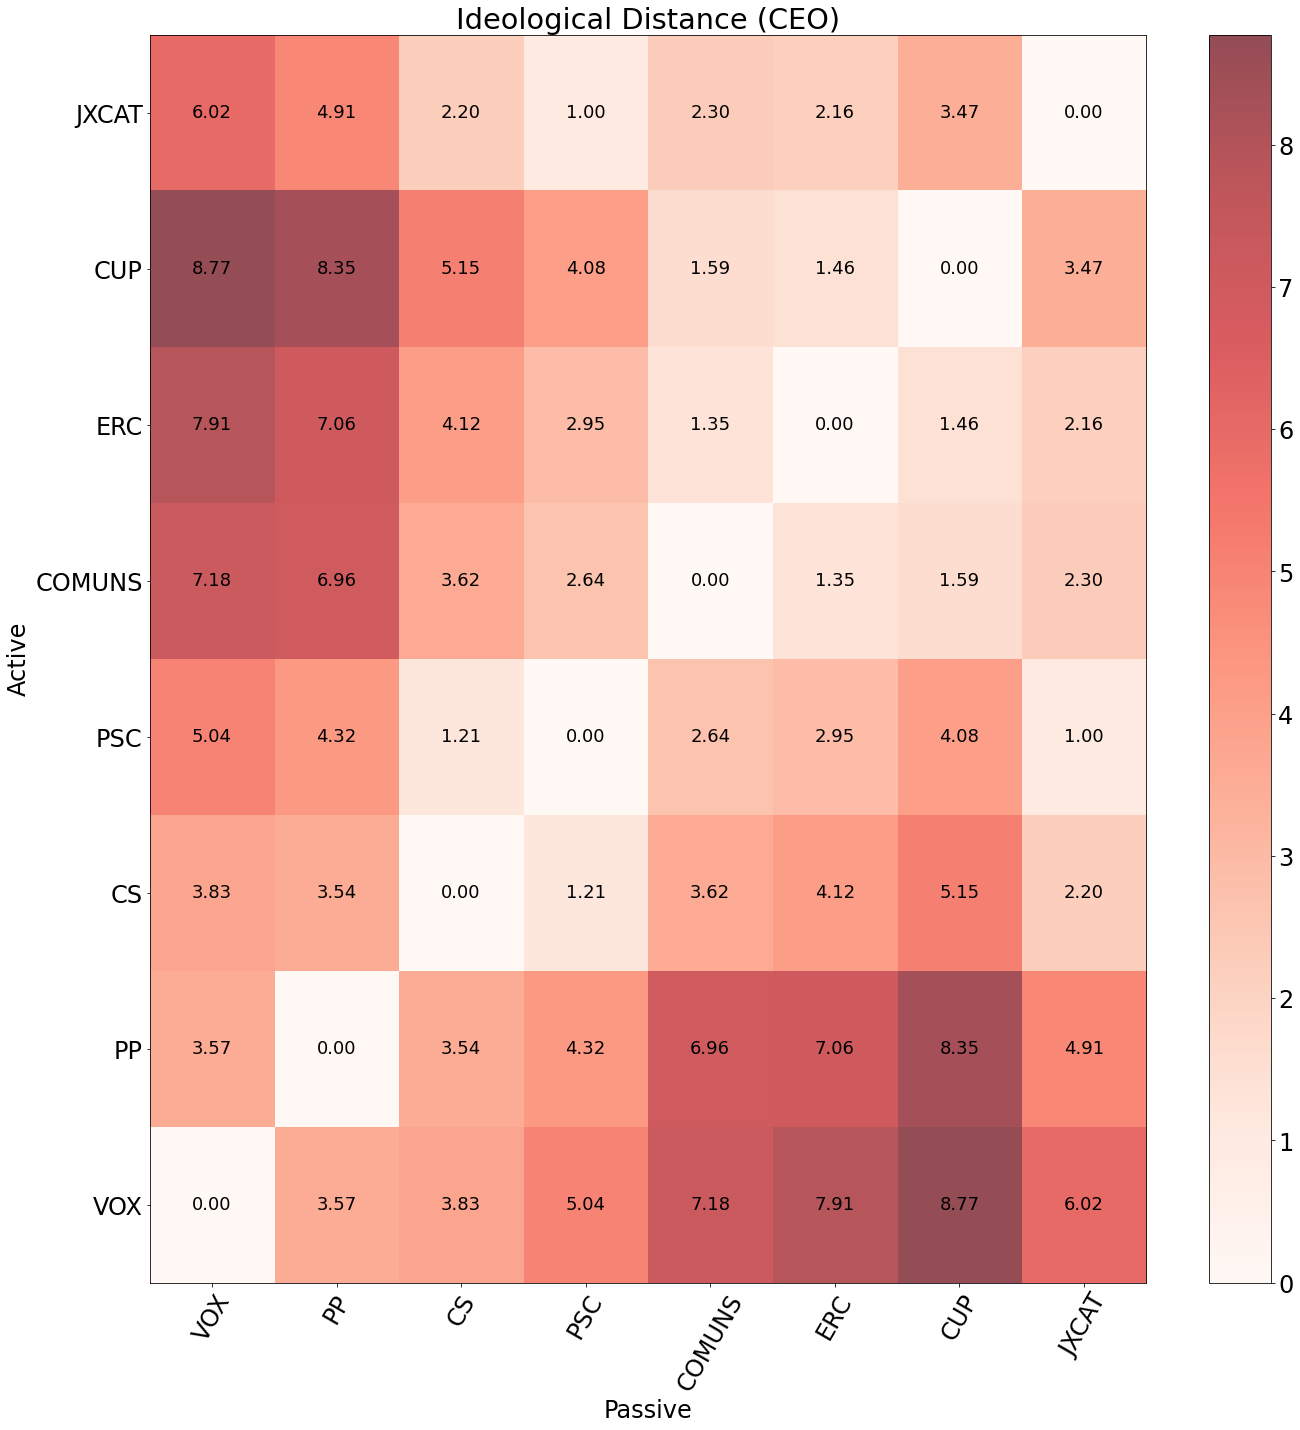

In [20]:
################
# PLOT HEATMAP #
################

def plot_heatmap(m, x_values, y_values, title, xlabel, ylabel, save_fig=False, label_rotation=None):
    """
        Creates a heatmap image from a numpy matrix.

    :param m: 2-dimensional numpy matrix with values to plot
    :param x_values: list of strings for xticks
    :param y_values: list of strings for yticks
    :param title: string, title of the plot
    :param xlabel: string, label of the x axis
    :param ylabel: string, label of the y axis
    :param save_fig: False / "show" / figname , do not show imatge / show it inline / write it to pdf (figure name)
    :param label_rotation: None / int, whether to rotate x ticks (degrees)
    :return:
    """
    
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 1, 1)

    im = ax.imshow(m.transpose(), origin='lower', cmap='Reds', alpha=0.7, aspect='auto')
    #im = ax.imshow(m.transpose(), origin='lower', cmap='jet', alpha=0.7)

    # Colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Loop over data dimensions and create text annotations.
    mt = m.transpose()
    for i in range(len(x_values)):
        for j in range(len(y_values)):
            text = ax.text(j, i, "{:.2f}".format(mt[i, j]), ha="center", va="center", color="black", alpha=1, fontsize=18)

    # Named ticks
    ax.set_xticks(np.arange(len(x_values)))
    ax.set_yticks(np.arange(len(y_values)))
    ax.set_xticklabels(x_values)
    ax.set_yticklabels(y_values)

    # Axis labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Rotate x labels
    if label_rotation:
        plt.xticks(rotation=label_rotation)

    fig.tight_layout()
    plt.title(title)
    
    plt.rcParams.update({'font.size': 24})

    # Output result
    if not save_fig:
        pass
    elif save_fig == "show":
        plt.show()
    else:
        plt.savefig(save_fig + '.pdf', format='pdf', dpi=600)
        plt.close()

        
######INPUT DATA#####

m = matrix
x_values = COMMUNITIES_LIST
y_values = COMMUNITIES_LIST
title = "Ideological Distance (CEO)"
xlabel = "Passive"
ylabel = "Active"
save_fig = "show"

plot_heatmap(m, x_values, y_values, title, xlabel, ylabel, save_fig, 60)

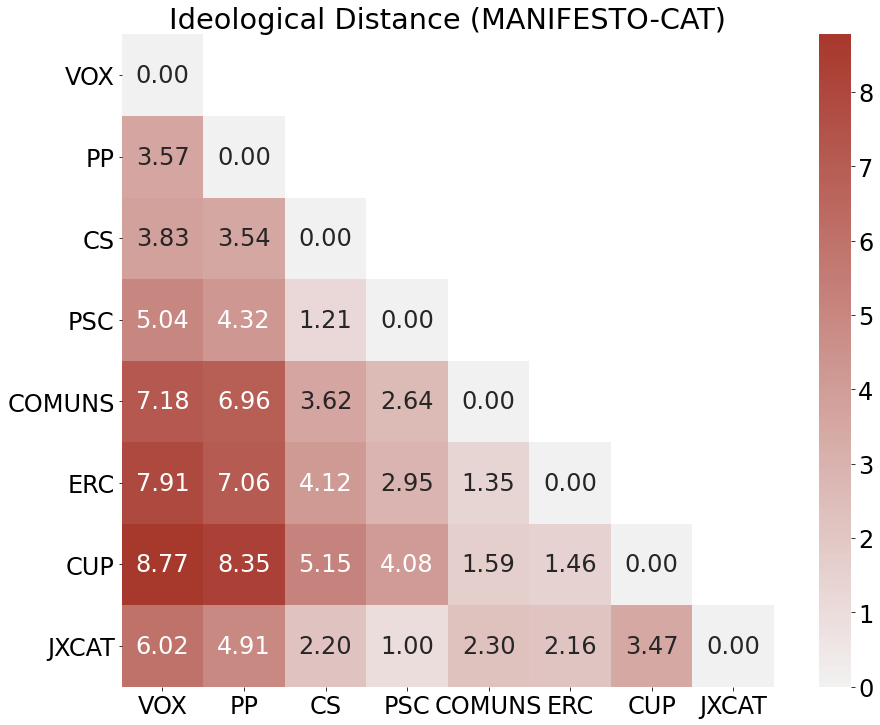

In [21]:
################################
# PLOT HEATMAP (NO REDUNDANCY) #
################################

matrix_df = pd.DataFrame(data=matrix,    # values
              index=COMMUNITIES_LIST,    # 1st column as index
              columns=COMMUNITIES_LIST)  # 1st row as the column names

# Calculate pairwise-correlation
m2 = matrix_df.corr()

# Create a mask
mask = np.triu(np.ones_like(m2, dtype=bool))

np.fill_diagonal(mask, False)

# Create a custom divergin palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                            n=9, center="light", as_cmap=True)

plt.figure(figsize=(16, 12))
sns.heatmap(matrix_df, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap)

plt.title("Ideological Distance (MANIFESTO-CAT)")

#plt.savefig("CAT-HEATMAP-MANIFESTO.png")
plt.show()

In [9]:
###########################################
#          REGIONAL MANIFESTO MAD         #
###########################################

CIS_ideological_position ={}

CIS_ideological_position['vox_es'] = [7.66]
CIS_ideological_position['populares'] = [6.68]
CIS_ideological_position['CiudadanosCs'] = [5.79]
CIS_ideological_position['PSOE'] = [4.27]
CIS_ideological_position['MasMadrid__'] = [3.34]
CIS_ideological_position['PODEMOS'] = [1.37]


print(CIS_ideological_position)

{'vox_es': [7.66], 'populares': [6.68], 'CiudadanosCs': [5.79], 'PSOE': [4.27], 'MasMadrid__': [3.34], 'PODEMOS': [1.37]}


In [10]:
########################
# PREPARE HEATMAP DATA #
########################


COMMUNITIES_LIST = ["VOX", "PP", "CS", "PSOE",  "MAS_MAD", "PODEMOS"]
PARTY_NAMES_LIST = ['vox_es', 'populares', 'CiudadanosCs', 'PSOE', 'MasMadrid__', 'PODEMOS']


matrix = np.zeros((len(COMMUNITIES_LIST),len(COMMUNITIES_LIST)))

for A in COMMUNITIES_LIST:
    for B in COMMUNITIES_LIST:
        a = np.array(CIS_ideological_position[PARTY_NAMES_LIST[COMMUNITIES_LIST.index(A)]])
        b = np.array(CIS_ideological_position[PARTY_NAMES_LIST[COMMUNITIES_LIST.index(B)]])
        distance = np.linalg.norm(a-b)
        #https://en.wikipedia.org/wiki/Euclidean_distance
                
        matrix[COMMUNITIES_LIST.index(A)][COMMUNITIES_LIST.index(B)] = distance #TO:DO: Revise SCALING!!
        
print(matrix)        

[[0.   0.98 1.87 3.39 4.32 6.29]
 [0.98 0.   0.89 2.41 3.34 5.31]
 [1.87 0.89 0.   1.52 2.45 4.42]
 [3.39 2.41 1.52 0.   0.93 2.9 ]
 [4.32 3.34 2.45 0.93 0.   1.97]
 [6.29 5.31 4.42 2.9  1.97 0.  ]]


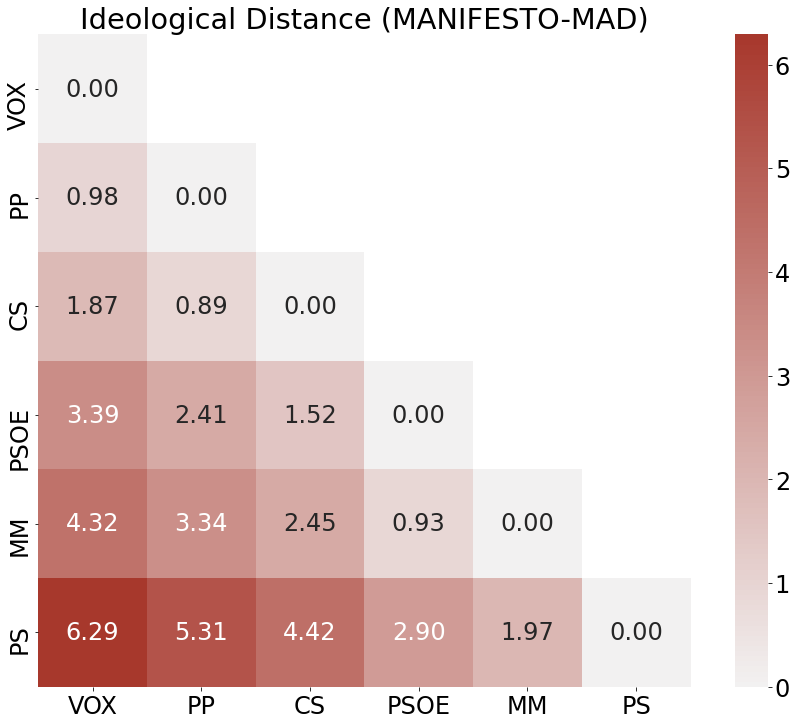

In [13]:
################################
# PLOT HEATMAP (NO REDUNDANCY) #
################################

COMMUNITIES_LIST = ["VOX", "PP", "CS", "PSOE",  "MM", "PS"]

matrix_df = pd.DataFrame(data=matrix,    # values
              index=COMMUNITIES_LIST,    # 1st column as index
              columns=COMMUNITIES_LIST)  # 1st row as the column names

# Calculate pairwise-correlation
m2 = matrix_df.corr()

# Create a mask
mask = np.triu(np.ones_like(m2, dtype=bool))

np.fill_diagonal(mask, False)

# Create a custom divergin palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                            n=9, center="light", as_cmap=True)

plt.figure(figsize=(16, 12))
sns.heatmap(matrix_df, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap)

plt.title("Ideological Distance (MANIFESTO-MAD)")

#plt.savefig("MAD-HEATMAP-MANIFESTO.png")
plt.show()

In [14]:
###########################################
#          REGIONAL MANIFESTO AND         #
###########################################

CES_ideological_position ={}

CES_ideological_position['vox_es'] = [7.01]
CES_ideological_position['populares'] = [5.79]
CES_ideological_position['CiudadanosCs'] = [5.98]
CES_ideological_position['PSOE'] = [4.34]
CES_ideological_position['PODEMOS'] = [2.20]
CES_ideological_position['AdelanteAND'] = [2.20]


print(CES_ideological_position)

{'vox_es': [7.01], 'populares': [5.79], 'CiudadanosCs': [5.98], 'PSOE': [4.34], 'PODEMOS': [2.2], 'AdelanteAND': [2.2]}


In [15]:
########################
# PREPARE HEATMAP DATA #
########################


COMMUNITIES_LIST = ["VOX", "PP", "CS", "PSOE", "POR_AND", "ADELANTE_AND"]
PARTY_NAMES_LIST = ['vox_es', 'populares','CiudadanosCs', 'PSOE', 'PODEMOS', 'AdelanteAND']


matrix = np.zeros((len(COMMUNITIES_LIST),len(COMMUNITIES_LIST)))

for A in COMMUNITIES_LIST:
    for B in COMMUNITIES_LIST:
        a = np.array(CES_ideological_position[PARTY_NAMES_LIST[COMMUNITIES_LIST.index(A)]])
        b = np.array(CES_ideological_position[PARTY_NAMES_LIST[COMMUNITIES_LIST.index(B)]])
        distance = np.linalg.norm(a-b)
        #https://en.wikipedia.org/wiki/Euclidean_distance
                
        matrix[COMMUNITIES_LIST.index(A)][COMMUNITIES_LIST.index(B)] = distance #TO:DO: Revise SCALING!!
        
print(matrix)  

[[0.   1.22 1.03 2.67 4.81 4.81]
 [1.22 0.   0.19 1.45 3.59 3.59]
 [1.03 0.19 0.   1.64 3.78 3.78]
 [2.67 1.45 1.64 0.   2.14 2.14]
 [4.81 3.59 3.78 2.14 0.   0.  ]
 [4.81 3.59 3.78 2.14 0.   0.  ]]


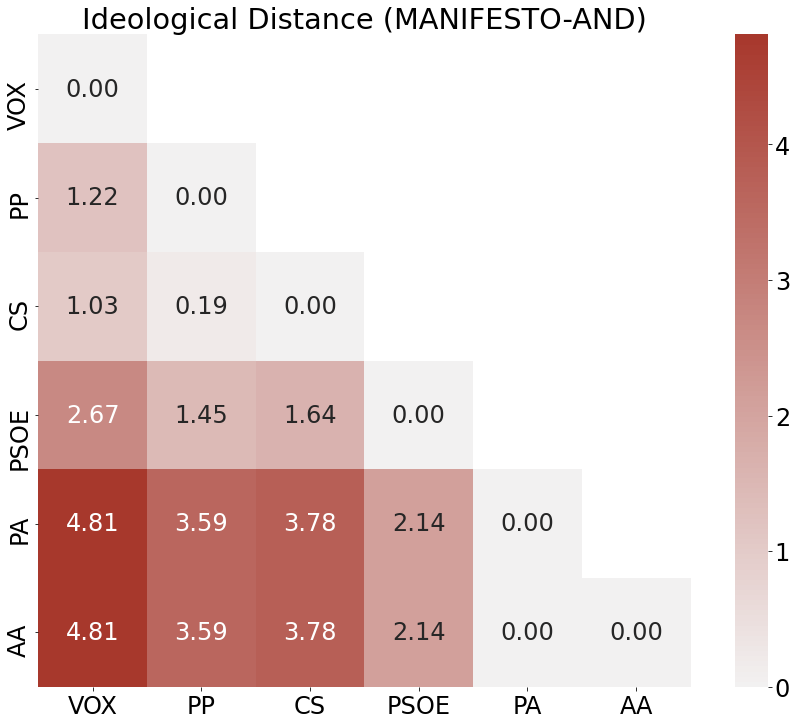

In [16]:
################################
# PLOT HEATMAP (NO REDUNDANCY) #
################################

COMMUNITIES_LIST = ["VOX", "PP", "CS", "PSOE", "PA", "AA"]

matrix_df = pd.DataFrame(data=matrix,    # values
              index=COMMUNITIES_LIST,    # 1st column as index
              columns=COMMUNITIES_LIST)  # 1st row as the column names

# Calculate pairwise-correlation
m2 = matrix_df.corr()

# Create a mask
mask = np.triu(np.ones_like(m2, dtype=bool))

np.fill_diagonal(mask, False)

# Create a custom divergin palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                            n=9, center="light", as_cmap=True)

plt.figure(figsize=(16, 12))
sns.heatmap(matrix_df, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap)

plt.title("Ideological Distance (MANIFESTO-AND)")

#plt.savefig("AND-HEATMAP-MANIFESTO.png")
plt.show()